# Masked Language Modelling and Sequence Classification with Bert

In this notebook, we leverage the "rotten_tomatoes" dataset from HuggingFace, containing movie reviews from Rotten Tomatoes. Our objectives are twofold:


1.   Perform Masked Language Modeling (MLM) on the training portion of provided dataset.
2.   Construct a classifier to discern between positive and negative reviews.

To achieve these goals, we employ a customized smaller version of BERT. This choice facilitates training and computation, ensuring efficiency and feasibility.

In [73]:
# Install necessary packages
%%capture
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate -U

UsageError: Line magic function `%%capture` not found.


In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

In [42]:
# Set up basic configurations for training
batch_size = 32
learning_rate = 1e-5
num_epoch = 5
num_labels = 2
np.random.seed(42)
torch.manual_seed(42)

# Select device for training (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset('rotten_tomatoes')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In all subsequent sections, we utilize the pre-trained BERT tokenizer. Thus, we begin by importing and initializing it here.

In [44]:
# Import BertTokenizer from the transformers library
from transformers import BertTokenizer

# Load the pre-trained BertTokenizer model 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We will utilize this configuration for the BERT model in subsequent sections.

In [45]:
# Import BertConfig from the transformers library
from transformers import BertConfig

# Define configuration parameters for the BERT model
config = BertConfig(
    hidden_size = 384,
    vocab_size= tokenizer.vocab_size,
    num_hidden_layers = 6,
    num_attention_heads = 6,
    intermediate_size = 1024,
    max_position_embeddings = 256
)

# 1 Masked Language Modeling

Masked Language Modeling (MLM) is a fundamental task in natural language processing (NLP) where a `head` is placed on top of a `BERT` (Bidirectional Encoder Representations from Transformers) model to `perform predictions`.
In MLM, certain words or tokens in a sentence are randomly masked or replaced with a special token, and the model is trained to predict the original words based on the context of the surrounding tokens. The objective of MLM is to encourage the model to learn contextual relationships between words and understand the overall structure and semantics of the language. During training, the model receives input sequences with masked tokens and is trained to generate the correct tokens for the masked positions. MLM serves as a crucial pre-training step in learning rich contextual representations of words, which can be transferred to downstream tasks such as text classification, named entity recognition, and question answering.
![](https://editor.analyticsvidhya.com/uploads/22971fig-3.png)
---

## 1.1 Dateset preparation for MLM

In [46]:
# Define a function to preprocess text data for masked language modeling (MLM)
def mlm_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    return {
        **input_info,
        'labels': input_info['input_ids']
        }

# Apply the mlm_map_function to the dataset for masked language modeling (MLM)
mlm_dataset = dataset.map(mlm_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

In [47]:
# Import DataCollatorForLanguageModeling from transformers
from transformers import DataCollatorForLanguageModeling

# Create a data collator for MLM training
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a DataLoader for MLM training
train_dataloader = torch.utils.data.DataLoader(
    mlm_dataset['train'],
    collate_fn=collate_fn,
    batch_size=batch_size
    )


## 1.2 BertModel + MLMHead + Custom trainer

In [48]:
class MLMHead(nn.Module):
    """
    Multi-Layer Perceptron (MLP) head for Masked Language Modeling (MLM) task.

    Parameters:
        bert_model (torch.nn.Module): BERT model.
        hidden_size (int): Size of the hidden layers in the MLP head. Default is 384.
        vocab_size (int): Size of the vocabulary. Default is 30522.
    """

    def __init__(self, device, bert_model, hidden_size=384, vocab_size=30522):
        super(MLMHead, self).__init__()
        
        # The BERT model that provides the embeddings
        self.bert_model = bert_model
        
        # A dense layer to project the hidden states to a larger space
        self.dense = nn.Linear(hidden_size, hidden_size).to(device)
        
        # Activation function (usually GELU for BERT)
        self.activation = nn.GELU()
        
        # Layer normalization
        self.layernorm = nn.LayerNorm(hidden_size).to(device)
        
        # Final linear layer to project back to the vocabulary size
        self.decoder = nn.Linear(hidden_size, vocab_size).to(device)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the MLMHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the MLM head.
        """
        # Get the embeddings from the BERT model
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden states
        last_hidden_states = outputs.last_hidden_state
        
        # Apply the dense layer
        x = self.dense(last_hidden_states)
        
        # Apply activation function
        x = self.activation(x)
        
        # Apply layer normalization
        x = self.layernorm(x)
        
        # Decode the hidden states back to the vocabulary size
        output = self.decoder(x)
        
        return output


In [58]:
from transformers import BertModel

# Initialize the BERT model with the custom configuration
bert = BertModel(config).to(device)

# Initialize the MLMHead with the bert model
mlm_model = MLMHead(device=device, bert_model=bert, hidden_size=config.hidden_size, vocab_size=config.vocab_size)

# Define an optimizer (Adam is commonly used)
optimizer = optim.Adam(mlm_model.parameters(), lr=1e-4)

# Define the loss function (CrossEntropyLoss for classification tasks)
criterion = nn.CrossEntropyLoss()

In [59]:
# Set model to training mode
mlm_model.train()

# Number of training epochs
epochs = 3
losses = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0  # To keep track of the loss for each epoch

    # Loop through batches in the dataloader
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
        # Get input_ids and attention_mask from the batch
        input_ids = batch['input_ids'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        attention_mask = batch['attention_mask'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = batch['labels'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Zero the gradients before backward pass
        optimizer.zero_grad()

        # Forward pass
        outputs = mlm_model(input_ids=input_ids, attention_mask=attention_mask)

        # Reshape outputs and labels to match the required format for CrossEntropyLoss
        outputs = outputs.view(-1, config.vocab_size)
        labels = labels.view(-1)

        # Calculate the loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        # Backward pass to calculate gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_loss += loss.item()

    # Calculate and print the average loss for this epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} / {epochs}, Loss: {avg_epoch_loss:.4f}")


Training Epoch 1:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1 / 3, Loss: 7.6846


Training Epoch 2:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 2 / 3, Loss: 6.8597


Training Epoch 3:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 3 / 3, Loss: 6.6718


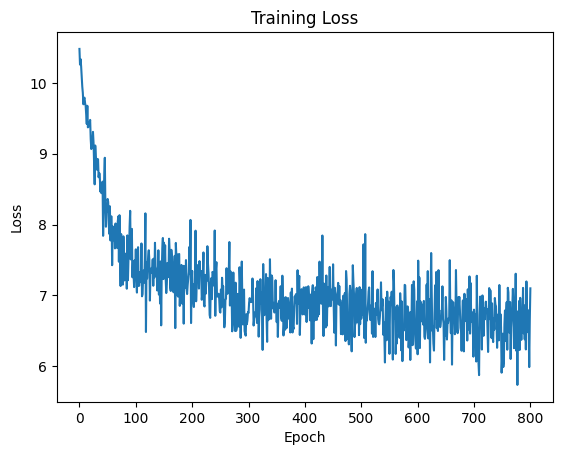

In [60]:
# Plot the losse for every batch in training process
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 1.3 BertForMaskedLM + huggingface trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForMaskedLM` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.

In [61]:
from transformers import BertForMaskedLM, Trainer, TrainingArguments
from datasets import DatasetDict

In [62]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

# Apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename the columns to the names expected by the Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format of the datasets to PyTorch tensors
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
model = BertForMaskedLM(config)

In [63]:
model = BertForMaskedLM(config)

In [67]:
training_args = TrainingArguments(
    output_dir="./results",           # output directory
    overwrite_output_dir=True,        # overwrite the content of the output directory
    num_train_epochs=3,               # number of training epochs
    per_device_train_batch_size=16,   # batch size for training
    save_steps=10_000,                # save checkpoint every 10,000 steps
    save_total_limit=2,               # limit the total amount of checkpoints
    prediction_loss_only=True,        # only calculate the loss
    report_to="none",
)

In [68]:
trainer = Trainer(
    model=model,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                # training arguments, defined above
    train_dataset=tokenized_datasets["train"],    # training dataset
    data_collator=collate_fn,          # data collator for dynamic padding
)

In [69]:
# Train the model
trainer.train()

Step,Training Loss
500,7.704900
1000,6.943500
1500,6.837800


TrainOutput(global_step=1602, training_loss=7.142966547857658, metrics={'train_runtime': 207.9509, 'train_samples_per_second': 123.058, 'train_steps_per_second': 7.704, 'total_flos': 332700357519360.0, 'train_loss': 7.142966547857658, 'epoch': 3.0})

# 2 Sequence Classification

When you look at how `BERT encodes` text, you'll see that it creates a `vector` for each word in the input sentence. But for basic classification tasks, we don't need all those individual word vectors.

Instead, we can just use the `first token's vector` because it captures the overall meaning of the sentence. BERT conveniently provides this vector for us in a special variable called `pooler_output`. So, in our classifier model, we'll use this pooler_output as the input for our classification head.
![BERT pooler output](https://miro.medium.com/max/1100/1*Or3YV9sGX7W8QGF83es3gg.webp)

## 2.1 Dataset preparation for sequence classification

In [78]:
# Define a function to preprocess text data for classification
def cls_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], truncation=True, max_length=128, padding=True)
    return {
        **input_info,
        'labels': rows['label']
        }

# Apply the cls_map_function to the dataset for classification
cls_dataset = dataset.map(cls_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [79]:
# Import DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding

# Create a data collator with padding
col_fn = DataCollatorWithPadding(
    tokenizer, return_tensors='pt', padding='longest',
)

# Create a DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    cls_dataset['train'],
    batch_size=batch_size,
    collate_fn=col_fn,
    shuffle=True
)

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(
    cls_dataset['test'],
    batch_size=batch_size,
    collate_fn=col_fn,
)

## 2.2 BertModel + ClassifierHead + Custom trainer

In [81]:
class ClassifierHead(nn.Module):
    """
    Classifier head for classification tasks.

    Parameters:
        embedding_model (torch.nn.Module): BERT model.
        num_classes (int): Number of classes for classification. Default is 2.
    """

    def __init__(self, embedding_model, num_classes=2):
        super().__init__()
        # BERT model to get embeddings
        self.embedder = embedding_model
        
        # Classification layer (Dense layer)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        
        # Sigmoid activation function for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the ClassifierHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the classifier head.
        """
        # Get the embeddings from the BERT model
        outputs = self.embedder(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the pooled output, which represents the [CLS] token
        pooled_output = outputs.pooler_output
        
        # Pass the pooled output through the classification layer
        logits = self.classifier(pooled_output)
        
        return logits  # Return raw logits


In [82]:
# Define the function to compute metrics
import evaluate
accuracy = evaluate.load("accuracy")

# Define the BERT model
bert = BertModel(config=config)

# Define the classifier head
cls_model = ClassifierHead(embedding_model=bert, num_classes=2)

# Define an optimizer (Adam is commonly used)
optimizer = optim.Adam(cls_model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

In [86]:
num_epochs = 3  # Set the number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# Move model to device
cls_model.to(device)

for epoch in range(num_epochs):
    cls_model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Print the start of an epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits = cls_model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute loss
        loss = criterion(logits, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

        # Print loss every 100 steps
        if (i + 1) % 100 == 0:
            print(f"Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions.double() / total_predictions
    print(f"Epoch {epoch + 1} completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Optionally, you can evaluate on the test set after each epoch and print the results
    cls_model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = cls_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            val_running_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            val_correct_predictions += torch.sum(preds == labels)
            val_total_predictions += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = val_correct_predictions.double() / val_total_predictions
    print(f"Validation | Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}")
    print("-" * 50)  # Separator between epochs


Epoch 1/3
Step [100/267], Loss: 0.4434
Step [200/267], Loss: 0.3681
Epoch 1 completed. Loss: 0.2691, Accuracy: 0.8917
Validation | Loss: 0.5040 | Accuracy: 0.7720
--------------------------------------------------
Epoch 2/3
Step [100/267], Loss: 0.1555
Step [200/267], Loss: 0.1297
Epoch 2 completed. Loss: 0.2194, Accuracy: 0.9155
Validation | Loss: 0.5384 | Accuracy: 0.7861
--------------------------------------------------
Epoch 3/3
Step [100/267], Loss: 0.1524
Step [200/267], Loss: 0.5733
Epoch 3 completed. Loss: 0.1751, Accuracy: 0.9298
Validation | Loss: 0.5683 | Accuracy: 0.7814
--------------------------------------------------


## 2.3 BertForSequenceClassification + Hugginface Trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForSequenceClassification` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.(You can include any additional required attributes to configuration.)

In [89]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import numpy as np
import torch
import pandas as pd

# Define configuration parameters for BERT
config = BertConfig(
    hidden_size=384,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1024,
    max_position_embeddings=256,
    num_labels=2  # Number of labels for classification
)

# Load BERT model for sequence classification
model = BertForSequenceClassification(config=config)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_total_limit=2,
    report_to="none"  # Disable external reporting tools like wandb
)

# Define metrics computation
from datasets import load_metric
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cls_dataset['train'],
    eval_dataset=cls_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_34/2970492941.py:37: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Epoch,Training Loss,Validation Loss,Accuracy
1,0.618700,0.623285,0.645403
2,0.439000,0.549632,0.717636
3,0.286900,0.534910,0.761726


{'eval_loss': 0.5349099040031433, 'eval_accuracy': 0.7617260787992496, 'eval_runtime': 0.7265, 'eval_samples_per_second': 1467.279, 'eval_steps_per_second': 92.221, 'epoch': 3.0}
